In [55]:
import pandas as pd
import numpy as np
!pip install pandas-ta
import pandas_ta as ta

from tensorflow.keras.layers import LSTM,Dense,Dropout,BatchNormalization,Bidirectional,Input,Conv1D,Flatten,Conv1D,MaxPooling1D
from tensorflow.keras.activations import relu,sigmoid,tanh,linear
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
# from keras_tuner.tuners import BayesianOptimization
# from keras_tuner.engine.hyperparameters import HyperParameters
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, BatchNormalization, Dropout, Flatten, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
# from keras_tuner.tuners import BayesianOptimization
from tensorflow.keras.callbacks import EarlyStopping
import  matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split



In [56]:
df = pd.read_csv('/content/drive/MyDrive/DATA/SPX_Data/CBOE_DLY_SPX, 30.csv')

In [57]:
# df.dropna(inplace=True)

In [58]:
df = df.drop(columns='Volume',axis=1)
df.set_index('time',inplace=True)


In [59]:
df['next_hour_Close'] = df['close'].shift(-1)
df['target'] =  df['next_hour_Close'] - df['close']
df['ema5'] = ta.ema(df['close'] , length=5)
df['ema10'] = ta.ema(df['close'] , length=10)
# delta = df['close'].diff()
df['upper_shadow'] = df['high'] - np.maximum(df['open'], df['close'])
df['lower_shadow'] = np.minimum(df['open'], df['close']) - df['low']
df['body'] = abs(df['close'] - df['open'])
df['candle_range'] = df['high'] - df['low']
df['atr'] = df['high'] - df['low']
df['atr'] = df['atr'].rolling(14).mean()

# gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
# loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
# rs = gain / loss
# df['RSI'] = 100 - (100 / (1 + rs))
# df['ema20'] = ta.ema(df['close'] , length=20)
# df['ema50'] = ta.ema(df['close'] , length=50)
# df['ema200'] = ta.ema(df['close'] , length=200)
df['rsi'] = ta.rsi(df['close'] , length=14)
macd = ta.macd(df['close'], fast=12, slow=26, signal=9)
df = pd.concat([df,macd],axis=1)
df['pivot'] = (df['high'] + df['low'] + df['close']) / 3
df['support_1'] = (2 * df['pivot']) - df['high']
df['support_2'] = df['pivot'] - (df['high'] - df['low'])
df['resistance_1'] = (2 * df['pivot']) - df['low']
df['resistance_2'] = df['pivot'] + (df['high'] - df['low'])
bollinger = ta.bbands(df['close'],length=20,std=2)
df = pd.concat([df,bollinger],axis=1)
stochastic = ta.stoch(df['high'], df['low'], df['close'], k=14, d=3, smooth_k=3)
df = pd.concat([df, stochastic], axis=1)
adx = ta.adx(df['high'], df['low'], df['close'], length=14)
df = pd.concat([df, adx], axis=1)
def fibonacci_retracement(df):
    high = df['high'].max()
    low = df['low'].min()

    diff = high - low

    df['fibonaccilevel2'] = high - 0.382 * diff
    df['fibonaccilevel3'] = high - 0.5 * diff
    df['fibonaccilevel4'] = high - 0.618 * diff
    df['fibonaccilevel5'] = high - 0.764 * diff

    return df

# fibonacci_retracement(df)

def stochastic_oscillator(df, period=14, ma_period=3):
    df['L14'] = df['low'].rolling(window=period).min()
    df['H14'] = df['high'].rolling(window=period).max()
    df['%K'] = (df['close'] - df['L14']) * 100 / (df['H14'] - df['L14'])
    df['%D'] = df['%K'].rolling(window=ma_period).mean()
    return df
stochastic_oscillator(df)

# Additional pivot-based levels
df['support_3'] = df['low'] - 2 * (df['high'] - df['pivot'])
df['resistance_3'] = df['high'] + 2 * (df['pivot'] - df['low'])
# Fibonacci levels (common ratios)
fib_range = df['high'] - df['low']
df['fib_236'] = df['high'] - fib_range * 0.236
df['fib_382'] = df['close'] + fib_range * 0.382  # Common retracement
df['fib_618'] = df['close'] - fib_range * 0.618  # Golden ratio
# Woodie's variation (uses 2*close in calculation)
df['woodie_pivot'] = (df['high'] + df['low'] + 2 * df['close']) / 4
df['woodie_s1'] = 2 * df['woodie_pivot'] - df['high']
df['woodie_r1'] = 2 * df['woodie_pivot'] - df['low']
# Camarilla system (uses different multipliers)
df['camarilla_s1'] = df['close'] - (df['high'] - df['low']) * 1.1 / 4
df['camarilla_r1'] = df['close'] + (df['high'] - df['low']) * 1.1 / 4
# Midpoints between key levels
df['mid_support'] = (df['support_1'] + df['support_2']) / 2
df['mid_resistance'] = (df['resistance_1'] + df['resistance_2']) / 2
# Alternative pivot calculation (includes open price)
df['alt_pivot'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
# Moving average of pivot points
df['pivot_ma7'] = df['pivot'].rolling(window=7).mean()
df['pivot_ma21'] = df['pivot'].rolling(window=21).mean()
# Price range calculations
df['daily_range'] = df['high'] - df['low']
df['range_pct'] = (df['daily_range'] / df['close']) * 100

df['HA_Close'] = (df['open'] + df['high'] + df['low'] + df['close']) / 4
df['HA_open'] = (df['open'].shift(1) + df['close'].shift(1)) / 2
df['HA_high'] = df[['high', 'HA_open', 'HA_Close']].max(axis=1)
df['HA_low'] = df[['low', 'HA_open', 'HA_Close']].min(axis=1)
df['HA_open'].iloc[0] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2


<ipython-input-59-7af911b48948>:88: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['HA_open'].iloc[0] = (df['open'].iloc[0] + df['close'].iloc[0]) / 2


In [60]:
# df.dropna(inplace=True)

In [61]:
# df.set_index('date',inplace=True)

In [62]:
df.columns.tolist()

['open',
 'high',
 'low',
 'close',
 'next_hour_Close',
 'target',
 'ema5',
 'ema10',
 'upper_shadow',
 'lower_shadow',
 'body',
 'candle_range',
 'atr',
 'rsi',
 'MACD_12_26_9',
 'MACDh_12_26_9',
 'MACDs_12_26_9',
 'pivot',
 'support_1',
 'support_2',
 'resistance_1',
 'resistance_2',
 'BBL_20_2.0',
 'BBM_20_2.0',
 'BBU_20_2.0',
 'BBB_20_2.0',
 'BBP_20_2.0',
 'STOCHk_14_3_3',
 'STOCHd_14_3_3',
 'ADX_14',
 'DMP_14',
 'DMN_14',
 'L14',
 'H14',
 '%K',
 '%D',
 'support_3',
 'resistance_3',
 'fib_236',
 'fib_382',
 'fib_618',
 'woodie_pivot',
 'woodie_s1',
 'woodie_r1',
 'camarilla_s1',
 'camarilla_r1',
 'mid_support',
 'mid_resistance',
 'alt_pivot',
 'pivot_ma7',
 'pivot_ma21',
 'daily_range',
 'range_pct',
 'HA_Close',
 'HA_open',
 'HA_high',
 'HA_low']

In [63]:
df.dropna(inplace=True)

In [64]:
features = [#'open',
#  'high',
#  'low',
#  'close',
#  'next_hour_Close',
#  'target',
  # 'ema5',
  # 'ema10',
#  'upper_shadow',
#  'lower_shadow',
#  'body',
#  'candle_range',
  # 'atr',
#  'rsi',
#  'MACD_12_26_9',
  # 'MACDh_12_26_9',
#  'MACDs_12_26_9',
#  'pivot',
#  'support_1',
  # 'support_2',
  # 'resistance_1',
  # 'resistance_2',
#  'BBL_20_2.0',
#  'BBM_20_2.0',
#  'BBU_20_2.0',
  # 'BBB_20_2.0',
#  'BBP_20_2.0',
#  'STOCHk_14_3_3',
#  'STOCHd_14_3_3',
#  'ADX_14',
#  'DMP_14',
#  'DMN_14',
#  'L14',
#  'H14',
#  '%K',
#  '%D',
#  'support_3',
#  'resistance_3',
#  'fib_236',
#  'fib_382',
#  'fib_618',
   'woodie_pivot',
  # 'woodie_s1',
  # 'woodie_r1',
#  'camarilla_s1',
#  'camarilla_r1',
#  'mid_support',
#  'mid_resistance',
#  'alt_pivot',
#  'pivot_ma7',
#  'pivot_ma21',
  # 'daily_range',
  # 'range_pct',
#  'HA_Close',
#  'HA_open',
#  'HA_high',
#  'HA_low']
]
target = ['next_hour_Close']

# close              0.999833
# camarilla_s1       0.999827
# camarilla_r1       0.999825
# woodie_pivot       0.999824
# fib_382            0.999819
# pivot              0.999818
# woodie_s1          0.999813
# support_1          0.999810
# woodie_r1          0.999809
# resistance_1       0.999804
# alt_pivot          0.999803
# fib_618            0.999802
# low                0.999782
# mid_support        0.999779
# high               0.999773
# mid_resistance     0.999770
# support_2          0.999737
# resistance_2       0.999722
# open               0.999720
# ema5               0.999698
# support_3          0.999639
# resistance_3       0.999621
# ema10              0.999494
# pivot_ma7          0.999487
# ema20              0.999074
# L14                0.998902
# BBM_20_2.0         0.998797
# H14                0.998785
# pivot_ma21         0.998697
# BBL_20_2.0         0.998270
# BBU_20_2.0         0.998088
# ema50              0.997838
# ema200             0.992243

In [65]:
X = df[features].values
y = df[target].values.reshape(-1, 1)

In [66]:
x_scaler = StandardScaler()
y_scaler = StandardScaler()
X_scaled = x_scaler.fit_transform(X)
y_scaled = y_scaler.fit_transform(y)

In [67]:
Sequence_len = 40

def creat_sequences(X,y,sequence_len):
  X_seq = []
  y_seq = []
  for i in range(len(X)-sequence_len):
    X_seq.append(X[i:i+sequence_len])
    y_seq.append(y[i+sequence_len])
  return np.array(X_seq),np.array(y_seq)

In [68]:
X_final,y_final = creat_sequences(X_scaled,y_scaled,Sequence_len)

In [69]:
print(X_final.shape)
print(y_final.shape)

(10599, 40, 1)
(10599, 1)


In [70]:
split_index = int(len(X_final)*0.90)
x_train = X_final[:split_index]
y_train = y_final[:split_index]
x_test = X_final[split_index:]
y_test = y_final[split_index:]

In [71]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(9539, 40, 1)
(9539, 1)
(1060, 40, 1)
(1060, 1)


In [72]:
# [I 2025-03-08 10:42:02,283] Trial 25 finished with value: 0.0008266468066722155 and parameters: {'n_lstm_layers': 1, 'n_dense_layers': 1, 'learning_rate': 0.002241032085627275, 'batch_size': 32, 'lstm_units_0': 384, 'lstm_units_1': 160, 'lstm_units_2': 320, 'lstm_dropout_0': 0.0, 'lstm_dropout_1': 0.5, 'lstm_dropout_2': 0.1, 'lstm_l2_0': 5.549602976953121e-05, 'lstm_l2_1': 8.136400649959104e-05, 'lstm_l2_2': 0.009904854205630113, 'dense_units_0': 48, 'dense_units_1': 256, 'dense_units_2': 112, 'dense_dropout_0': 0.0, 'dense_dropout_1': 0.1, 'dense_dropout_2': 0.2, 'dense_l2_0': 1.0993810979042252e-06, 'dense_l2_1': 0.0002639949450923612, 'dense_l2_2': 5.63058462711279e-05}. Best is trial 25 with value: 0.0008266468066722155.


model = Sequential()
model.add(Input(shape=(Sequence_len, x_train.shape[2])))
model.add(LSTM(384,kernel_regularizer=l2(5.549602976953121e-05)))
model.add(Dense(48,kernel_regularizer=l2(1.0993810979042252e-06)))
model.add(Dense(1, activation='linear'))


model.summary()




Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 384)                 │         592,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 48)                  │          18,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 611,425 (2.33 MB)

 Trainable params: 611,425 (2.33 MB)

 Non-trainable params: 0 (0.00 B)

In [73]:
Es = EarlyStopping(monitor='val_mae',patience=10)
learning_rate =  0.002241032085627275
model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mse', metrics=['mae'])
# history = model.fit(x_train, y_train, epochs=200, validation_data=(x_train, y_train),callbacks=Es)
history = model.fit(x_train, y_train, epochs=200, batch_size=32,validation_data=(x_train, y_train))

Epoch 1/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 0.0189 - mae: 0.0604 - val_loss: 0.0012 - val_mae: 0.0233
Epoch 2/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 8s 26ms/step - loss: 0.0013 - mae: 0.0247 - val_loss: 0.0011 - val_mae: 0.0223
Epoch 3/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - loss: 0.0012 - mae: 0.0239 - val_loss: 0.0011 - val_mae: 0.0237
Epoch 4/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0012 - mae: 0.0232 - val_loss: 0.0015 - val_mae: 0.0281
Epoch 5/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0013 - mae: 0.0243 - val_loss: 0.0011 - val_mae: 0.0218
Epoch 6/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - loss: 0.0012 - mae: 0.0227 - val_loss: 0.0011 - val_mae: 0.0230
Epoch 7/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.0011 - mae: 0.0218 - val_loss: 0.0010 - val_mae: 0.0210
Epoch 8/200
299/299 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0010 - mae: 0.0211 - val_loss: 0.0011 - val_mae: 0.0236
Epoch 9/200
299/299 ━━━━━━━━━━━━━━━━━━━━

In [74]:
test_loss, test_mae = model.evaluate(x_test, y_test)
print(f'Test Loss: {test_loss}, Test MAE: {test_mae}')
# Test Loss: 0.0007733969250693917, Test MAE: 0.017693864181637764



34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6.2038e-04 - mae: 0.0167
Test Loss: 0.0007715405663475394, Test MAE: 0.018309276551008224


In [75]:
y_pred = model.predict(x_test)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


In [76]:
y_pred = y_scaler.inverse_transform(y_pred)
y_test = y_scaler.inverse_transform(y_test)


In [77]:
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test,y_pred)
print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"R-squared: {r2}")
# MAE: 11.976406231574297
# MSE: 343.1247494796402
# RMSE: 18.52362679065955
# R-squared: 0.9727945800158362

MAE: 12.392951006043631
MSE: 341.0622088695247
RMSE: 18.46786963538363
R-squared: 0.9729581132019958


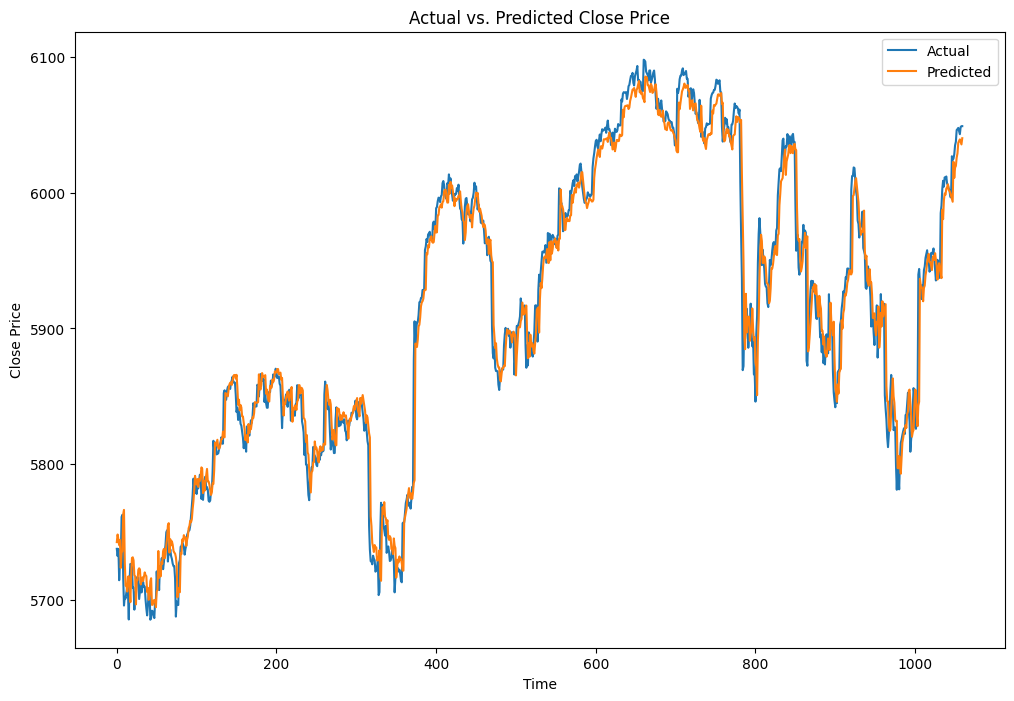

In [78]:
plt.figure(figsize=(12, 8))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Actual vs. Predicted Close Price')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [79]:
df_results = pd.DataFrame({
    'Actual': y_test.flatten(),
    'Predicted': y_pred.flatten()
}, index=df.index[-len(y_test):])

df_results.to_csv('best30min.csv')

# print("Results saved to 'best30min.csv'")
# from google.colab import files

# files.download('best30min.csv')

In [80]:
def evaluate_predictions(y_test, y_pred):
    # محاسبه معیارهای دقت مدل
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

    print(f"Mean Absolute Error (MAE): {mae:.4f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    # بررسی جهت حرکت قیمت‌ها
    correct_direction = np.sum(np.sign(y_pred[1:] - y_pred[:-1]) == np.sign(y_test[1:] - y_test[:-1]))
    accuracy = correct_direction / (len(y_test) - 1) * 100

    print(f"Trend Direction Accuracy: {accuracy:.2f}%")

In [81]:
evaluate_predictions(y_test, y_pred)


Mean Absolute Error (MAE): 12.3930
Root Mean Squared Error (RMSE): 18.4679
Mean Absolute Percentage Error (MAPE): 0.21%
Trend Direction Accuracy: 50.42%
